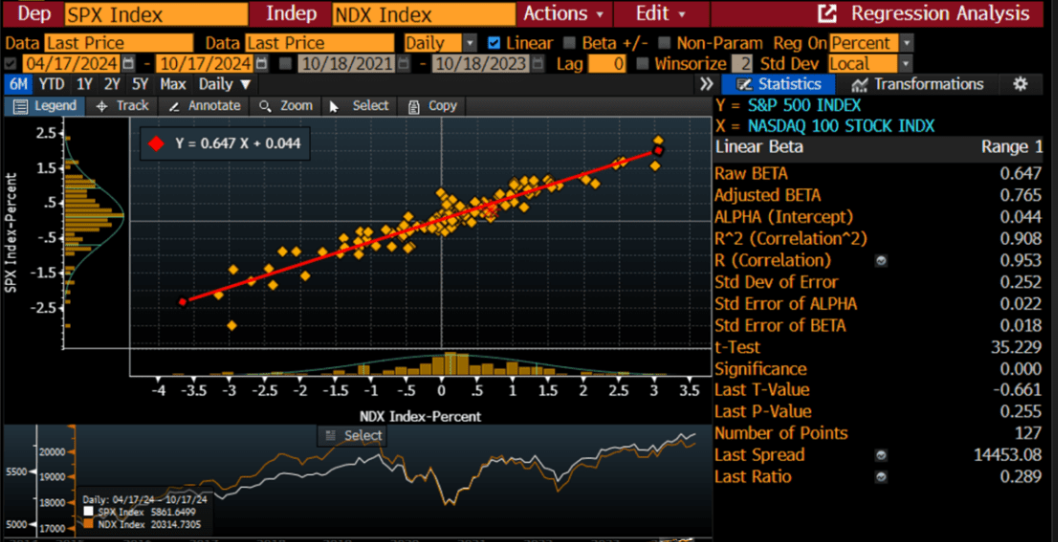

# Machine Learning, caso con Regresión

En este notebook veremos cómo usar algoritmos de regresión para predecir la rentabilidad de una acción. Una vez realizadas nuestras predicciones, desarrollaremos una estrategia de trading basada en nuestro modelo y compararemos su rendimiento con una estrategia simple de compra y retención.

In [1]:
!pip install yfinance --upgrade
!pip install ta
!pip install backtesting
!pip install --upgrade plotly==5.20.0
!pip install mplfinance
#!pip install pandas_ta==0.3.14b0
#!pip install numpy==1.24.3
!pip install catboost # Install catboost
#!pip install quantstats

  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29412 sha256=e16a273a21be2cb714b4396b138e95850a8e761109684d5164b3148573c37247
  Stored in directory: /root/.cache/pip/wheels/a1/d7/29/7781cc5eb9a3659d032d7d15bdd0f49d07d2b24fec29f44bc4
Successfully built ta
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 191.4/191.4 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.7/15.7 MB 90.3 MB/s eta 0:00:00
  Attempting uninstall: plotly
    Found existing installation: plotly 5.24.1
    Uninstalling plotly-5.24.1:
      Successfully uninstalled plotly-5.24.1
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.0/75.0 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 7.8 MB/s eta 0:00:00


In [2]:
import yfinance as yf
import ta
from backtesting import Backtest, Strategy
from backtesting.lib import crossover
import plotly.graph_objects as go
import mplfinance as mpf
#import pandas_ta as pdta
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
#
from plotly.subplots import make_subplots
import plotly.io as pio
pio.renderers.default = 'colab'
#
#import quantstats as qs

/usr/local/lib/python3.11/dist-packages/backtesting/_plotting.py:55: UserWarning: Jupyter Notebook detected. Setting Bokeh output to notebook. This may not work in Jupyter clients without JavaScript support, such as old IDEs. Reset with `backtesting.set_bokeh_output(notebook=False)`.
  warnings.warn('Jupyter Notebook detected. '


In [3]:
# Machine Learning
from sklearn.metrics import roc_auc_score, roc_curve, auc

# Modelos
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier


# Eliminamos advertencias
import warnings
warnings.filterwarnings("ignore")

# Berkshire-Hataway

In [4]:
# Descargar datos
brk = yf.download('BRK-B', auto_adjust=False, end='2025-05-16').dropna()
brk.columns = brk.columns.droplevel(1)
brk

[*********************100%***********************]  1 of 1 completed


Price,Adj Close,Close,High,Low,Open,Volume
Date,,,,,,
1996-05-09,23.200001,23.200001,24.400000,22.200001,22.200001,4290000
1996-05-10,24.000000,24.000000,24.200001,23.600000,24.000000,1060000
1996-05-13,23.900000,23.900000,24.100000,23.299999,24.000000,700000
1996-05-14,23.600000,23.600000,24.100000,23.100000,24.000000,310000
1996-05-15,23.200001,23.200001,23.700001,23.000000,23.600000,545000
...,...,...,...,...,...,...
2025-05-09,513.739990,513.739990,515.909973,510.250000,514.250000,3621400
2025-05-12,514.299988,514.299988,520.299988,510.250000,520.299988,6368000
2025-05-13,511.880005,511.880005,515.750000,511.799988,515.640015,4504100


In [5]:
brk.head()

Price,Adj Close,Close,High,Low,Open,Volume
Date,,,,,,
1996-05-09,23.200001,23.200001,24.400000,22.200001,22.200001,4290000
1996-05-10,24.000000,24.000000,24.200001,23.600000,24.000000,1060000
1996-05-13,23.900000,23.900000,24.100000,23.299999,24.000000,700000
1996-05-14,23.600000,23.600000,24.100000,23.100000,24.000000,310000
1996-05-15,23.200001,23.200001,23.700001,23.000000,23.600000,545000


In [75]:
# Gráfico con subplots
fig = make_subplots(
    rows=2, cols=1, shared_xaxes=True, vertical_spacing=0.05,
    row_heights=[0.70,0.30], subplot_titles=("Precio BRK ","Volumen")
)

# Velas japonesas
fig.add_trace(go.Candlestick(
    x=brk.index,
    open=brk['Open'],
    high=brk['High'],
    low=brk['Low'],
    close=brk['Adj Close'],
    name='Velas',
    increasing_line_color='green',
    decreasing_line_color='red'
), row=1, col=1)

# Volumen
fig.add_trace(go.Bar(
    x=brk.index,
    y=brk['Volume'],
    name='Volumen',
    marker_color='red',
    opacity=0.5
), row=2, col=1)

# Layout final
fig.update_layout(
    title='BRK - Precio Histórico Ajustado ',
    xaxis_rangeslider_visible=False,
    height=700,
    template='ggplot2'
)

fig.add_annotation(text='Berkshire Hathaway Inc. (BRK-B)',
                    font=dict(color='black', size=40),
                    xref='paper', yref='paper',
                    x=0.5, y=0.65,
                    showarrow=False,
                    opacity=0.2)
#fig.show()


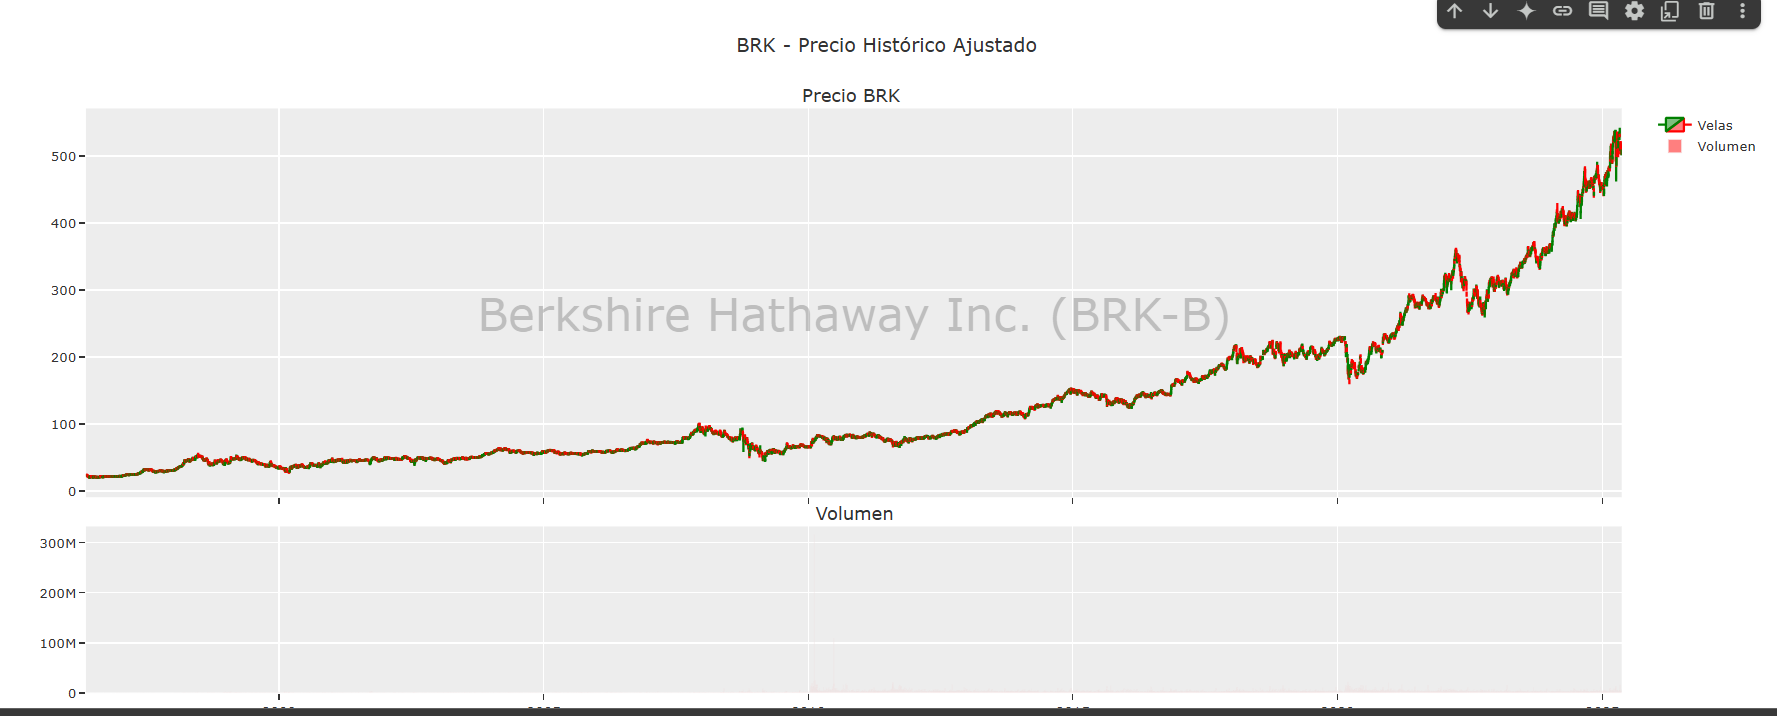

Antes de avanzar a los pasos de preprocesamiento de datos, tenemos que dividir nuestro conjunto de datos en conjuntos de entrenamiento y prueba.

In [7]:
# Separando los datos
train = brk[brk.index.year <= 2017]
test = brk[brk.index.year >= 2018]

In [8]:
train

Price,Adj Close,Close,High,Low,Open,Volume
Date,,,,,,
1996-05-09,23.200001,23.200001,24.400000,22.200001,22.200001,4290000
1996-05-10,24.000000,24.000000,24.200001,23.600000,24.000000,1060000
1996-05-13,23.900000,23.900000,24.100000,23.299999,24.000000,700000
1996-05-14,23.600000,23.600000,24.100000,23.100000,24.000000,310000
1996-05-15,23.200001,23.200001,23.700001,23.000000,23.600000,545000
...,...,...,...,...,...,...
2017-12-22,197.919998,197.919998,199.679993,196.880005,199.240005,3786800
2017-12-26,197.570007,197.570007,198.570007,197.279999,197.970001,1769600
2017-12-27,198.690002,198.690002,198.820007,197.279999,197.500000,3343200


In [9]:
test

Price,Adj Close,Close,High,Low,Open,Volume
Date,,,,,,
2018-01-02,197.220001,197.220001,198.869995,195.960007,198.869995,4113000
2018-01-03,199.789993,199.789993,200.000000,197.000000,197.000000,3526700
2018-01-04,200.690002,200.690002,202.130005,200.009995,200.899994,3900000
2018-01-05,201.419998,201.419998,201.669998,199.309998,201.000000,4207600
2018-01-08,202.740005,202.740005,203.070007,199.800003,201.149994,3887900
...,...,...,...,...,...,...
2025-05-09,513.739990,513.739990,515.909973,510.250000,514.250000,3621400
2025-05-12,514.299988,514.299988,520.299988,510.250000,520.299988,6368000
2025-05-13,511.880005,511.880005,515.750000,511.799988,515.640015,4504100


# Ingeniería de Características


Definiremos una nueva función llamada feature_engineering, en la que crearemos nuevas características basadas en los datos disponibles para mejorar la capacidad predictiva de nuestros algoritmos de regresión.

El primer conjunto de características refleja el comportamiento diario del precio. La razón high_low_ratio indica la volatilidad midiendo la relación entre los precios máximos y mínimos. La razón open_adjclose_ratio captura la dirección general del mercado comparando los precios de apertura y cierre. Por último, la razón candle_to_wick_ratio representa la parte del rango de precios cubierta por el cuerpo de la vela, que representa la distancia entre los precios de apertura y cierre de cada día.
Las demás características son valores rezagados del precio de cierre ajustado. Desplazamos el precio de cierre uno, dos, tres y cinco días para capturar relaciones con sus valores anteriores. Además, calculamos la relación entre el precio de cierre actual y sus rezagos para capturar el impulso y las tendencias en un período de tiempo específico. Por ejemplo, una razón superior a 1 sugeriría un impulso alcista, lo que implicaría posibles precios de cierre más altos en los próximos días o incluso una reversión de precios.

Para analizar con más detalle el impulso y la tendencia, utilizamos la biblioteca de Análisis Técnico para calcular medias móviles simples de los precios de cierre. También calculamos las razones entre el precio de cierre y cada media móvil, indicando si el precio está por encima o por debajo de la media, a la vez que proporcioné información sobre el impulso y la tendencia actuales. Además, calculamos las razones entre medias móviles más cortas y más largas para capturar el impulso general y la tendencia de precios.

Añadimos indicadores técnicos clásicos como el CCI, el RSI y el OBV. Las características binarias indican si el RSI está sobrecomprado o sobrevendido. También creamos otras dos características que capturan las divergencias en el OBV durante los últimos 10 y 20 días.
Por último, calculamos los rendimientos diarios porcentuales y creamos una variable objetivo para las predicciones de nuestro modelo. La variable objetivo se deriva de los rendimientos diarios, pero se adelanta un día. Este cambio ayuda al modelo a comprender qué características del día actual influyeron en cambios positivos o negativos en el día siguiente.

In [10]:
# Ingeniería de Características
def feature_engineering(df):

    # Caracteristicas del comportamiento del precio
    df['high_low_ratio'] = df['High'] / df['Low']
    df['open_adjclose_ratio'] = df['Open'] / df['Adj Close']
    df['candle_to_wick_ratio'] = (df['Adj Close'] - df['Open']) / (df['High'] - df['Low'])
    df['candle_to_wick_ratio'] = df['candle_to_wick_ratio'].replace([np.inf, -np.inf], 0)

    # Valores rezagados
    df['Close_lag1'] = df['Adj Close'].shift(1)
    df['Close_lag2'] = df['Adj Close'].shift(2)
    df['Close_lag3'] = df['Adj Close'].shift(3)
    df['Close_lag5'] = df['Adj Close'].shift(5)

    # Relación cercana a los rezagos
    df['Close_lag1_ratio'] = df['Adj Close'] / df['Close_lag1']
    df['Close_lag2_ratio'] = df['Adj Close'] / df['Close_lag2']
    df['Close_lag3_ratio'] = df['Adj Close'] / df['Close_lag3']
    df['Close_lag5_ratio'] = df['Adj Close'] / df['Close_lag5']

    # Medias Moviles simples
    df['sma10'] = ta.trend.sma_indicator(df['Adj Close'], window = 10)
    df['sma20'] = ta.trend.sma_indicator(df['Adj Close'], window = 20)
    df['sma80'] = ta.trend.sma_indicator(df['Adj Close'], window = 80)
    df['sma100'] = ta.trend.sma_indicator(df['Adj Close'], window = 100)

    # Ratio cercano a los promedios
    df['Close_sma10_ratio'] = df['Adj Close'] / df['sma10']
    df['Close_sma20_ratio'] = df['Adj Close'] / df['sma20']
    df['Close_sma80_ratio'] = df['Adj Close'] / df['sma80']
    df['Close_sma100_ratio'] = df['Adj Close'] / df['sma100']


    # Relación entre la SMA más corta y la más larga
    df['sma10_sma20_ratio'] = df['sma10'] / df['sma20']
    df['sma20_sma80_ratio'] = df['sma20'] / df['sma80']
    df['sma80_sma100_ratio'] = df['sma80'] / df['sma100']
    df['sma10_sma80_ratio'] = df['sma10'] / df['sma80']
    df['sma20_sma100_ratio'] = df['sma20'] / df['sma100']

    # Indicadores Técnicos
    df['rsi'] = ta.momentum.RSIIndicator(df['Adj Close']).rsi()
    df['rsi_overbought'] = (df['rsi'] >= 70).astype(int)
    df['rsi_oversold'] = (df['rsi'] <= 30).astype(int)
    df['cci'] = ta.trend.cci(df['High'], df['Low'], df['Adj Close'], window=20, constant=0.015)
    df['obv'] = ta.volume.OnBalanceVolumeIndicator(close=df['Adj Close'], volume=df['Volume']).on_balance_volume()
    df['obv_divergence_10_days'] = df['obv'].diff().rolling(10).sum() - df['Adj Close'].diff().rolling(10).sum()
    df['obv_divergence_20_days'] = df['obv'].diff().rolling(20).sum() - df['Adj Close'].diff().rolling(20).sum()

    # Retorno diario %
    df['returns_in_%'] = np.round((df['Adj Close'].pct_change()) * 100, 2)

    # Variable objetivo: los rendimientos diarios se trasladaron a un día anterior
    df['target'] = df['returns_in_%'].shift(-1)

    # Quitamos valores Null
    df.dropna(inplace = True)
    return df  # df

Ahora aplicamos la función creada anteriormente a los conjuntos de entrenamiento y de prueba. Una vez hecho esto, dividimos los conjuntos de datos en características independientes $(X)$ y variable objetivo $(y)$.


In [11]:
train = feature_engineering(train)
test = feature_engineering(test)

In [12]:
train.head(10)

Price,Adj Close,Close,High,Low,Open,Volume,high_low_ratio,open_adjclose_ratio,candle_to_wick_ratio,Close_lag1,...,sma20_sma100_ratio,rsi,rsi_overbought,rsi_oversold,cci,obv,obv_divergence_10_days,obv_divergence_20_days,returns_in_%,target
Date,,,,,,,,,,,,,,,,,,,,,
1996-09-30,21.459999,21.459999,21.600000,21.280001,21.280001,55000,1.015038,0.991612,0.562496,21.360001,...,1.003602,52.451051,0,0,19.657101,3355000,-114999.619999,129999.360001,0.47,-1.03
1996-10-01,21.240000,21.240000,21.459999,21.160000,21.459999,70000,1.014178,1.010358,-0.733333,21.459999,...,1.005182,46.664615,0,0,-41.256578,3285000,-39999.580000,44999.719999,-1.03,0.85
1996-10-02,21.420000,21.420000,21.440001,21.200001,21.200001,75000,1.011321,0.989729,0.916665,21.240000,...,1.007388,51.389821,0,0,-27.149134,3360000,140000.139999,94999.580000,0.85,-0.09
1996-10-03,21.400000,21.400000,21.459999,21.340000,21.459999,40000,1.005623,1.002804,-0.500000,21.420000,...,1.009749,50.850740,0,0,-21.807010,3320000,35000.260000,99999.500000,-0.09,0.00
1996-10-04,21.400000,21.400000,21.459999,21.320000,21.360001,70000,1.006567,0.998131,0.285708,21.400000,...,1.011643,50.850740,0,0,-39.279503,3390000,65000.340000,139999.640001,0.00,-0.47
1996-10-07,21.299999,21.299999,21.440001,21.299999,21.440001,95000,1.006573,1.006573,-1.000000,21.400000,...,1.012408,47.934925,0,0,-68.148253,3295000,0.220001,-24999.939999,-0.47,-0.66
1996-10-08,21.160000,21.160000,21.340000,21.160000,21.240000,50000,1.008507,1.003781,-0.444443,21.299999,...,1.013002,44.120635,0,0,-135.707713,3245000,-114999.600000,-19999.959999,-0.66,0.57
1996-10-09,21.280001,21.280001,21.280001,21.100000,21.160000,130000,1.008531,0.994361,0.666670,21.160000,...,1.013634,47.944242,0,0,-132.434548,3375000,65000.199999,70000.039999,0.57,-0.28
1996-10-10,21.219999,21.219999,21.320000,21.160000,21.320000,35000,1.007561,1.004713,-0.625003,21.280001,...,1.013727,46.240492,0,0,-113.586652,3340000,-14999.740000,-4999.779999,-0.28,-0.28


In [13]:
test.head(10)

Price,Adj Close,Close,High,Low,Open,Volume,high_low_ratio,open_adjclose_ratio,candle_to_wick_ratio,Close_lag1,...,sma20_sma100_ratio,rsi,rsi_overbought,rsi_oversold,cci,obv,obv_divergence_10_days,obv_divergence_20_days,returns_in_%,target
Date,,,,,,,,,,,,,,,,,,,,,
2018-05-24,194.830002,194.830002,196.259995,193.919998,196.059998,3206200,1.012067,1.006313,-0.525640,195.949997,...,0.973009,43.251152,0,0,-63.869518,2988100,-1.445119e+07,-1.118020e+07,-0.57,-0.35
2018-05-25,194.149994,194.149994,194.750000,193.210007,193.889999,3031000,1.007971,0.998661,0.168828,194.830002,...,0.972395,41.790912,0,0,-89.110808,-42900,-1.356449e+07,-1.677010e+07,-0.35,-2.20
2018-05-29,189.869995,189.869995,193.110001,188.619995,192.899994,8912100,1.023805,1.015958,-0.674832,194.149994,...,0.971918,34.008296,0,0,-181.593282,-8955000,-1.921199e+07,-2.143470e+07,-2.20,2.23
2018-05-30,194.100006,194.100006,194.899994,191.330002,191.899994,4307600,1.018659,0.988666,0.616251,189.869995,...,0.971985,44.924775,0,0,-86.427702,-4647400,-1.152440e+07,-2.036210e+07,2.23,-1.32
2018-05-31,191.529999,191.529999,194.289993,191.419998,194.289993,5787500,1.014993,1.014410,-0.961672,194.100006,...,0.972020,40.537200,0,0,-111.981263,-10434900,-2.023929e+07,-2.226410e+07,-1.32,0.37
2018-06-01,192.229996,192.229996,193.380005,191.589996,192.899994,3817800,1.009343,1.003485,-0.374299,191.529999,...,0.972680,42.193214,0,0,-116.497589,-6617100,-1.381729e+07,-1.338690e+07,0.37,-0.48
2018-06-04,191.300003,191.300003,193.410004,191.250000,193.000000,4444500,1.011294,1.008887,-0.787034,192.229996,...,0.972169,40.576400,0,0,-119.481089,-11061600,-1.512470e+07,-2.275050e+07,-0.48,-0.28
2018-06-05,190.770004,190.770004,191.399994,190.139999,191.369995,4325000,1.006627,1.003145,-0.476185,191.300003,...,0.971324,39.644057,0,0,-129.506349,-15386600,-2.245519e+07,-3.076759e+07,-0.28,1.69
2018-06-06,193.990005,193.990005,194.000000,191.570007,191.690002,4017500,1.012685,0.988144,0.946506,190.770004,...,0.971378,47.531980,0,0,-60.790531,-11369100,-2.159970e+07,-2.256050e+07,1.69,0.81


In [14]:
X_train = train.drop('target', axis = 1) # Independiente X
y_train = train.target # Variable Objetivo Y

X_test = test.drop('target', axis = 1) # Independiente X
y_test = test.target # Variable Target Y

Nuestros conjuntos de datos de entrenamiento y prueba ahora constan de un total de 38 atributos tras eliminar la variable objetivo de X_train y X_test.

Si bien contar con numerosas características en nuestros conjuntos de datos X puede ayudar a nuestro modelo a extraer la máxima información, algunas características pueden volverse redundantes y provocar un sobreajuste (overfitting). Para solucionar esto, realizaremos una selección univariante de características utilizando SelectKBest de Scikit-learn. Este método selecciona las características en función de sus puntuaciones, específicamente las k puntuaciones más altas.

SelectKBest aplica una prueba estadística de valor F para identificar las características más relevantes. En nuestro caso, utilizaremos la función `score_fun` = `f_regression`, que calcula el coeficiente de correlación de Pearson r entre cada característica y la variable objetivo continua. Es importante tener en cuenta que `f_regression` solo es adecuado para variables objetivo continuas y proporciona puntuaciones F y valores p como resultados.

Para determinar qué características seleccionaremos, definiremos un umbral para los valores p. En concreto, seleccionaremos únicamente aquellas características cuyo valor p sea inferior a 0,2. Este enfoque nos permite centrarnos en las características que presentan una relación estadísticamente significativa con la variable objetivo.

In [15]:
from sklearn.feature_selection import SelectKBest, f_regression

# SelectKBest
k_best = SelectKBest(score_func = f_regression, k = 38)

# Ajuste y transformación
X_train_kbest = k_best.fit_transform(X_train, y_train)
X_test_kbest = k_best.transform(X_test)

#índices y nombres de características
feature_indices = k_best.get_support(indices = True)
feature_names = X_train.columns[feature_indices]

#  p-values
p_values = k_best.pvalues_

#
features = []

# Seleccionamos p-values bajo 0.2
for feature, pvalue in zip(feature_names, p_values):
    if pvalue < 0.2:
        features.append(feature)

#
print("Características:")
print(features)

Selected Features:
['high_low_ratio', 'open_adjclose_ratio', 'candle_to_wick_ratio', 'Close_lag1_ratio', 'Close_lag5_ratio', 'Close_sma10_ratio', 'Close_sma20_ratio', 'Close_sma80_ratio', 'Close_sma100_ratio', 'sma10_sma20_ratio', 'sma10_sma80_ratio', 'rsi', 'rsi_oversold', 'cci', 'returns_in_%']


Tenemos una lista de todas las características seleccionadas según el valor p.

In [16]:
# Creación de nuevos conjuntos de datos X que contienen solo las características seleccionadas
X_train_kbest = X_train[features]
X_test_kbest = X_test[features]

In [17]:
X_train_kbest

Price,high_low_ratio,open_adjclose_ratio,candle_to_wick_ratio,Close_lag1_ratio,Close_lag5_ratio,Close_sma10_ratio,Close_sma20_ratio,Close_sma80_ratio,Close_sma100_ratio,sma10_sma20_ratio,sma10_sma80_ratio,rsi,rsi_oversold,cci,returns_in_%
Date,,,,,,,,,,,,,,,
1996-09-30,1.015038,0.991612,0.562496,1.004682,0.997212,0.995916,1.002804,1.015702,1.006416,1.006916,1.019867,52.451051,0,19.657101,0.47
1996-10-01,1.014178,1.010358,-0.733333,0.989748,0.985158,0.987631,0.991874,1.005503,0.997015,1.004296,1.018096,46.664615,0,-41.256578,-1.03
1996-10-02,1.011321,0.989729,0.916665,1.008475,0.997207,0.996650,0.999300,1.013893,1.006683,1.002659,1.017301,51.389821,0,-27.149134,0.85
1996-10-03,1.005623,1.002804,-0.500000,0.999066,0.996276,0.996925,0.997204,1.012946,1.006926,1.000280,1.016070,50.850740,0,-21.807010,-0.09
1996-10-04,1.006567,0.998131,0.285708,1.000000,1.001873,0.998507,0.996368,1.013306,1.007970,0.997858,1.014821,50.850740,0,-39.279503,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-12-21,1.006811,0.999799,0.029625,1.005561,1.011339,1.005521,1.021476,1.065200,1.075057,1.015867,1.059351,68.457212,0,69.345340,0.56
2017-12-22,1.014222,1.006669,-0.471433,0.995123,1.000708,0.999869,1.012448,1.058759,1.068654,1.012581,1.058899,64.161504,0,55.904653,-0.49
2017-12-26,1.006539,1.002025,-0.310071,0.998232,0.991121,0.997662,1.007031,1.055729,1.065695,1.009391,1.058203,62.634301,0,46.269521,-0.18


Ahora, ejecutaremos diferentes algoritmos de regresión y seleccionaremos el que ofrezca el mayor rendimiento. Para ello, evaluaremos los algoritmos utilizando el R² y el Error Cuadrático Medio (RMSE).

Idealmente, buscamos un modelo con el R² más alto y el RMSE más bajo posible.

A continuación, ejecutaremos primero los algoritmos de regresión solo en X_train_kbest y X_test_kbest. Después, ejecutaremos los algoritmos de regresión en los conjuntos de datos X, que contienen todas las características disponibles. Seleccionaremos el modelo y las configuraciones que logren los mejores R² y RMSE.

In [18]:
# Importar modelos de regresión
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import ExtraTreesRegressor, GradientBoostingRegressor, AdaBoostRegressor, RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
# XGBoost y LightGBM
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor


# Mejores características
regressors = [
    LinearRegression(),
    Ridge(random_state = 42),
    ExtraTreesRegressor(random_state = 42),
    GradientBoostingRegressor(random_state = 42),
    KNeighborsRegressor(),
    XGBRegressor(random_state = 42),
    LGBMRegressor(random_state = 42),
    CatBoostRegressor(random_state = 42, verbose = False),
    AdaBoostRegressor(random_state = 42),
    RandomForestRegressor(random_state = 42)
]

# Importar métricas de evaluación
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np #

# Iteración de diferentes algorítmos
for reg in regressors:
    reg.fit(X_train_kbest, y_train)
    y_pred = reg.predict(X_test_kbest)
    r2 = r2_score(y_test, y_pred)
    #
    #
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    print(f'{type(reg).__name__}: R² = {r2:.2f}, Raíz Error Cadrático Medio = {rmse:.2f}')

LinearRegression: R² = -0.01, Raíz Error Cadrático Medio = 1.33
Ridge: R² = -0.01, Raíz Error Cadrático Medio = 1.33
ExtraTreesRegressor: R² = -0.06, Raíz Error Cadrático Medio = 1.37
GradientBoostingRegressor: R² = -0.01, Raíz Error Cadrático Medio = 1.34
KNeighborsRegressor: R² = -0.23, Raíz Error Cadrático Medio = 1.47
XGBRegressor: R² = -0.14, Raíz Error Cadrático Medio = 1.42
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001153 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3572
[LightGBM] [Info] Number of data points in the train set: 5349, number of used features: 15
[LightGBM] [Info] Start training from score 0.051712
LGBMRegressor: R² = -0.14, Raíz Error Cadrático Medio = 1.42
CatBoostRegressor: R² = -0.04, Raíz Error Cadrático Medio = 1.36
AdaBoostRegressor: R² = -0.04, Raíz Error Cadrático Medio = 1.35
RandomForestRegressor: R² = -0.05, Raíz Error Cadrático Medio = 1.36


In [19]:
# Todas las características
regressors = [
    LinearRegression(),
    Ridge(random_state = 42),
    ExtraTreesRegressor(random_state = 42),
    GradientBoostingRegressor(random_state = 42),
    KNeighborsRegressor(),
    XGBRegressor(random_state = 42),
    LGBMRegressor(random_state = 42),
    CatBoostRegressor(random_state = 42, verbose = False),
    AdaBoostRegressor(random_state = 42),
    RandomForestRegressor(random_state = 42)
]

# Importar métricas de evaluación
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np
# Iterando sobre diferentes algorítmos
for reg in regressors:
    reg.fit(X_train, y_train)
    y_pred = reg.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    # Raíz ECM
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    print(f'{type(reg).__name__}: R² = {r2:.2f}, Raiz Error Cuadrático Medio = {rmse:.2f}')

LinearRegression: R² = -0.26, Raiz Error Cuadrático Medio = 1.49
Ridge: R² = -0.28, Raiz Error Cuadrático Medio = 1.50
ExtraTreesRegressor: R² = -0.03, Raiz Error Cuadrático Medio = 1.35
GradientBoostingRegressor: R² = -0.28, Raiz Error Cuadrático Medio = 1.50
KNeighborsRegressor: R² = -1.02, Raiz Error Cuadrático Medio = 1.89
XGBRegressor: R² = -0.32, Raiz Error Cuadrático Medio = 1.53
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002313 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9184
[LightGBM] [Info] Number of data points in the train set: 5349, number of used features: 38
[LightGBM] [Info] Start training from score 0.051712
LGBMRegressor: R² = -0.09, Raiz Error Cuadrático Medio = 1.39
CatBoostRegressor: R² = -0.01, Raiz Error Cuadrático Medio = 1.34
AdaBoostRegressor: R² = -0.03, Raiz Error Cuadrático Medio = 

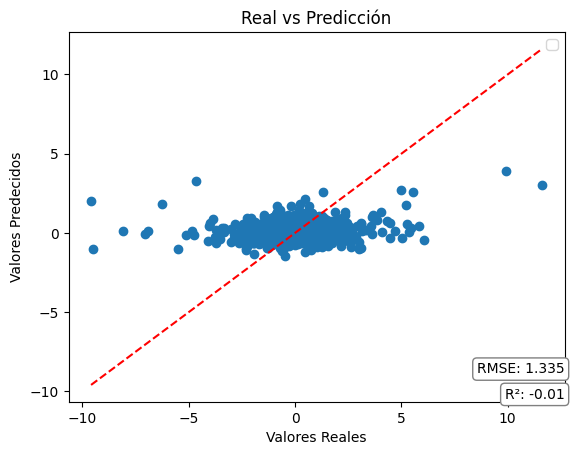

In [20]:
# Modelo CatBoostClassifier
model=CatBoostRegressor(random_state = 42,verbose=False)

# Fitting, testing, and computing scores
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
r2 = r2_score(y_test, y_pred)
# Calculate RMSE by taking the square root of MSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

# Plotting scatter plot – y_test x y_pred
plt.scatter(y_test, y_pred)
plt.xlabel('Valores Reales')
plt.ylabel('Valores Predecidos')
plt.title('Real vs Predicción')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
box = dict(boxstyle="round, pad=0.3", fc="white", ec="gray", lw=1)
plt.text(plt.xlim()[1], plt.ylim()[0]+0.02, f"R²: {r2:.2f}", ha='right', va='bottom', wrap = True, bbox = box)
plt.text(plt.xlim()[1], plt.ylim()[0]*0.85 + 0.02, f"RMSE: {rmse:.3f}", ha='right', va='bottom', wrap = True, bbox = box)

plt.legend()
plt.show()

Una vez más, es posible observar que nuestro modelo tiene dificultades para predecir grandes movimientos a la baja, pero aún parece capaz de predecir con bastante precisión grandes movimientos al alza.

A continuación, podemos observar la gráfica de importancia de las características para observar cuáles fueron más útiles para predecir la variable objetivo. Este gráfico nos mostrará las características en las que nuestro modelo se basa con mayor precisión para realizar predicciones.

In [21]:
#Retornos diarios y_pred x y_test
fig = go.Figure()
fig.add_trace(go.Scatter(x=np.arange(len(y_test)), y=y_test, mode='lines', name='Valores Reales'))
fig.add_trace(go.Scatter(x=np.arange(len(y_test)), y=y_pred, mode='lines', name='Predicción'))
fig.update_layout(title='Verdadero vs Predicción', xaxis_title='Index', yaxis_title='Valores')
fig.show()

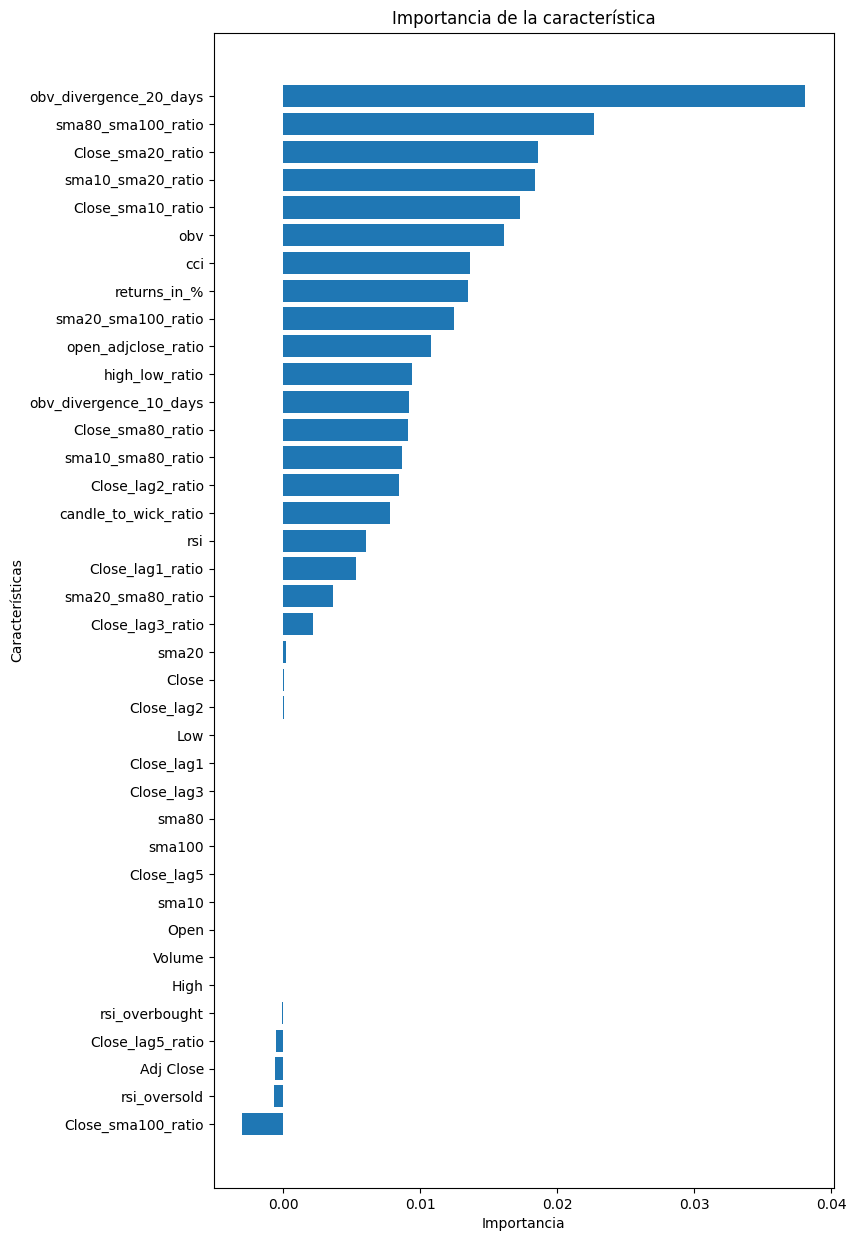

In [22]:
# Importar permutation_importance
from sklearn.inspection import permutation_importance

result = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42) # Cálculo de las importancias de características

# Cálculo de puntuaciones medias y obtención de nombres de características
importances = result.importances_mean
feature_names = X_test.columns

# Clasificación de características, importancia y nombres
indices = importances.argsort()[::1]
sorted_features = feature_names[indices]
sorted_importances = importances[indices]

# Gráfica de importancia de características
fig, ax = plt.subplots(figsize = (8,15))
ax.barh(sorted_features, sorted_importances)
ax.set_yticklabels(sorted_features)
ax.set_ylabel('Características')
ax.set_xlabel('Importancia')
ax.set_title('Importancia de la característica')
plt.show()

`permutation_importance` funciona reorganizando aleatoriamente cada columna del conjunto de datos individualmente, manteniendo las demás intactas. Esto se realiza para medir el impacto de un cambio en cada columna específica en las predicciones finales.

La importancia en el eje x simplemente muestra la diferencia entre la precisión del conjunto de datos original y la precisión después de reorganizar los valores de las columnas. Por ejemplo, podemos ver que reorganizar la columna `obv_divergence_20_days` afectaría considerablemente la precisión de nuestro modelo al realizar predicciones. Esto nos muestra que nuestro modelo funciona mejor antes de reorganizar los datos de esta columna específica.

Las características con valores de importancia inferiores a 0,0 simplemente no tienen tanta importancia para las predicciones generales. Los valores inferiores a cero simplemente indican que, aleatoriamente, las predicciones de los datos reorganizados obtuvieron un mejor rendimiento que las de los datos originales. Sin embargo, esto no implica necesariamente que debamos eliminar o modificar estas columnas.

Podemos observar que las características que hemos creado durante la ingeniería de características terminaron volviéndose importantes para las predicciones, especialmente aquellas que calculan las relaciones entre los promedios móviles, el indicador RSI, así como otras relaciones y los precios rezagados.

# Ajuste del modelo
La puntuación R² que obtuvimos, por ejemplo, no sería. Sin embargo,los mercados financieros son extremadamente complejos y no es fácil hacer predicciones sobre sus datos.

Usaremos la biblioteca `Optuna` para la optimización de hiperparámetros y encontrar la mejor configuración de parámetros para lograr la máxima puntuación posible para nuestro modelo.

Primero, definimos la función objetivo a continuación, que requiere muchos parámetros para ajustarse aleatoriamente y realizar predicciones utilizando el modelo GradientBoostingRegressor. Luego, devolvemos la puntuación del error cuadrático medio.

Ahora tenemos la intención de minimizar la puntuación RMSE, por lo que buscamos el valor RMSE más bajo posible. La función de optimización toma como entrada nuestra función objetivo, y n_trials = 100 significa que nuestra función objetivo se ejecutará 100 veces con la configuración aleatoria de parámetros del objeto `params` de la función objetivo anterior.

In [28]:
# Función Objetivo
def objective(trial):

    # Configuraciones de parámetros para iterar
    params = {
        'loss': trial.suggest_categorical('loss', ['squared_error', 'absolute_error', 'huber', 'quantile']),
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000, step=50),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 2, 20),
        'subsample': trial.suggest_uniform('subsample', 0.1, 1.0),
        'random_state': 42
    }

    # Ajuste y predicción
    tuning = GradientBoostingRegressor(**params)
    tuning.fit(X_train, y_train)
    preds = tuning.predict(X_test)

    #Cálculo de RMSE
    # Calculate MSE first
    mse = mean_squared_error(y_test, preds)
    # Then calculate RMSE by taking the square root
    rmse = np.round(np.sqrt(mse), 3)
    return rmse # Returining the score

In [25]:
#!pip install optuna
import optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 12.0 MB/s eta 0:00:00


#
#

In [29]:
study = optuna.create_study(direction = 'minimize') # Creating study
study.optimize(objective, n_trials = 100, show_progress_bar = True) # Running study

[I 2025-05-19 23:24:55,378] A new study created in memory with name: no-name-dbdee8a5-e25f-4e7c-a5b4-fd953057fe82


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-05-19 23:26:23,641] Trial 0 finished with value: 1.998 and parameters: {'loss': 'quantile', 'n_estimators': 500, 'learning_rate': 0.017333733722861407, 'max_depth': 8, 'min_samples_split': 9, 'min_samples_leaf': 17, 'subsample': 0.721331343617299}. Best is trial 0 with value: 1.998.
[I 2025-05-19 23:27:41,424] Trial 1 finished with value: 1.353 and parameters: {'loss': 'squared_error', 'n_estimators': 600, 'learning_rate': 0.014246915311709003, 'max_depth': 5, 'min_samples_split': 3, 'min_samples_leaf': 9, 'subsample': 0.8038727048389733}. Best is trial 1 with value: 1.353.
[I 2025-05-19 23:29:16,412] Trial 2 finished with value: 1.423 and parameters: {'loss': 'huber', 'n_estimators': 750, 'learning_rate': 0.08133963341218407, 'max_depth': 6, 'min_samples_split': 10, 'min_samples_leaf': 14, 'subsample': 0.6434028396250986}. Best is trial 1 with value: 1.353.
[I 2025-05-19 23:33:25,915] Trial 3 finished with value: 1.365 and parameters: {'loss': 'squared_error', 'n_estimators': 

#Imprimiendo la mejor configuración

In [30]:
print('Best parameters:', study.best_params) # La mejor configuración de parámetros
print('Best score:', study.best_value)

Best parameters: {'loss': 'huber', 'n_estimators': 200, 'learning_rate': 0.01693745628417444, 'max_depth': 3, 'min_samples_split': 14, 'min_samples_leaf': 5, 'subsample': 0.5193135276543805}
Best score: 1.315


El resultado anterior nos proporciona la mejor configuración de parámetros para el modelo `CatBoostRegressor`, así como el valor RMSE más bajo obtenido durante el estudio de optimización.

A continuación, instanciaremos de nuevo el modelo `CatBoostRegressor`, pasando `study.best_params`, para que se ejecute con los parámetros anteriores para ajustarse a nuestros datos de entrenamiento y realizar predicciones con los datos de prueba. A continuación, dibujaremos de nuevo un diagrama de dispersión que compare los valores de `y_pred` y  `y_test`.

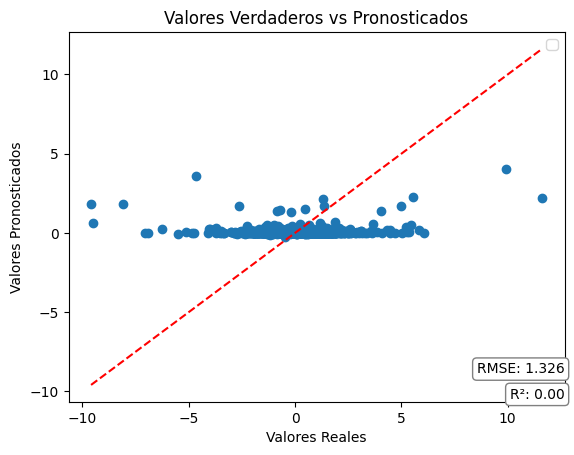

In [34]:
# Modelo con la mejor configuración de parámetros

best_params_for_catboost = study.best_params.copy()

# Quitamos parámetros que no son válidos para CatBoostRegressor
invalid_params = ['loss', 'min_samples_split', 'min_samples_leaf', 'subsample']
for param in invalid_params:
    if param in best_params_for_catboost:
        del best_params_for_catboost[param]


model = CatBoostRegressor(**best_params_for_catboost, verbose=False) #
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
r2 = r2_score(y_test, y_pred)
#
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

#  Scatter plot – y_test VS y_pred
plt.scatter(y_test, y_pred)
plt.xlabel('Valores Reales')
plt.ylabel('Valores Pronosticados')
plt.title('Valores Verdaderos vs Pronosticados')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
box = dict(boxstyle="round, pad=0.3", fc="white", ec="gray", lw=1)
plt.text(plt.xlim()[1], plt.ylim()[0]+0.02, f"R²: {r2:.2f}", ha='right', va='bottom', wrap = True, bbox = box)
plt.text(plt.xlim()[1], plt.ylim()[0]*0.85 + 0.02, f"RMSE: {rmse:.3f}", ha='right', va='bottom', wrap = True, bbox = box)

plt.legend()
plt.show()

In [36]:
# Retornos Diarios y_pred x y_test
fig = go.Figure()
fig.add_trace(go.Scatter(x=np.arange(len(y_test)), y=y_test, mode='lines', name='Valores Reales'))
fig.add_trace(go.Scatter(x=np.arange(len(y_test)), y=y_pred, mode='lines', name='Valores Pronosticados'))
fig.update_layout(title='Valores Reales vs Pronosticados', xaxis_title='Index', yaxis_title='Valores')
fig.show()

El gráfico confirma que el modelo no predice eficazmente retornos negativos significativos, como vimos previamente en el gráfico de dispersión y_pred x y_test.

También podemos revisar el gráfico de importancia de las características para ver cómo cambia con la nueva configuración de parámetros.

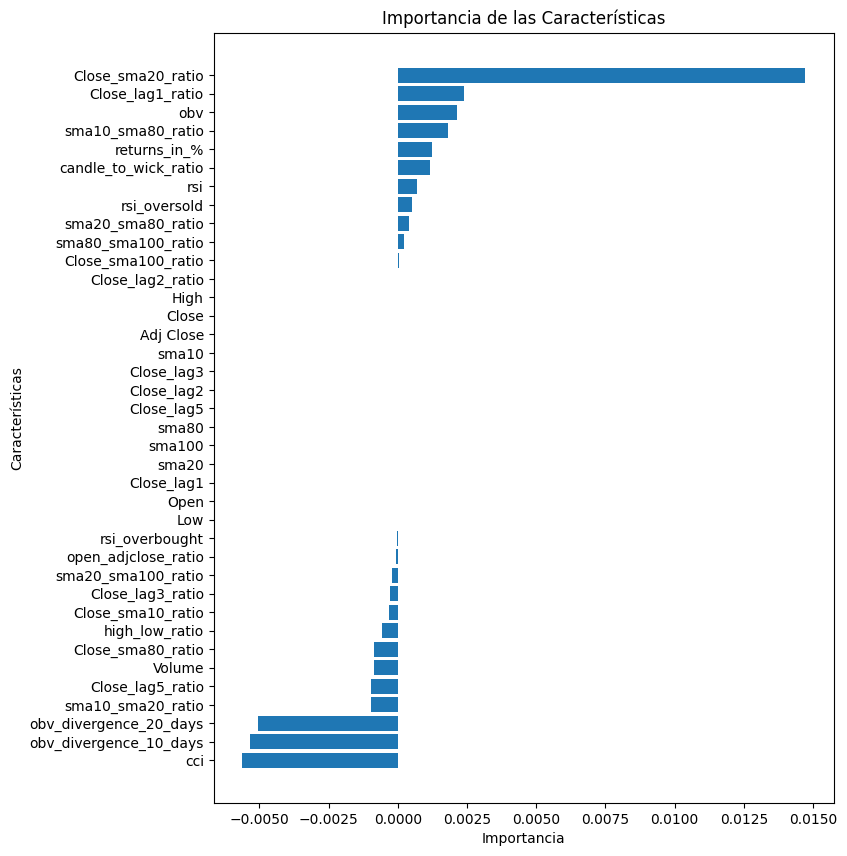

In [38]:
result = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42) #

importances = result.importances_mean
feature_names = X_test.columns

indices = importances.argsort()[::1]
sorted_features = feature_names[indices]
sorted_importances = importances[indices]

fig, ax = plt.subplots(figsize = (8,10))
ax.barh(sorted_features, sorted_importances)
ax.set_yticklabels(sorted_features)
ax.set_ylabel('Características')
ax.set_xlabel('Importancia')
ax.set_title('Importancia de las Características')
plt.show()


# Estrategia de Trading

Los algoritmos de regresión se utilizan cuando nuestra variable objetivo consiste en valores continuos, a diferencia de los valores binarios que utilizamos para realizar predicciones en la primera parte de esta serie de cuadernos dedicados al aprendizaje automático en el trading de acciones.

Por esta razón, debemos ser creativos al elegir la estrategia de trading que seguiremos según el modelo que hemos creado. Intuitivamente, podríamos diseñar una estrategia en la que compremos cuando el rendimiento previsto sea superior a 0 y vendamos en corto cuando sea inferior a 0, lo que sería un valor negativo.


In [39]:
y_pred

array([0.02574156, 0.02386683, 0.15651968, ..., 0.03341398, 0.03513971,
       0.09350695])

In [40]:
y_test

,target
Date,
2018-05-24,-0.35
2018-05-25,-2.20
2018-05-29,2.23
2018-05-30,-1.32
2018-05-31,0.37
...,...
2025-05-08,0.10
2025-05-09,0.11
2025-05-12,-0.47


Aunque ambos arrays tienen valores continuos, podemos separarlos en valores positivos o negativos. Por esta razón, crearé dos nuevos arrays llamados y_pred_class e y_test_class. Ambos recibirán valores 0 o 1 según su fila correspondiente en y_pred e y_test. Si el valor de retorno es mayor que 0, los arrays de clases contendrán un valor igual a 1. En caso contrario, se les asignará un valor igual a 0.

In [41]:
y_pred_class = np.where(y_pred > 0, 1, 0)
y_pred_class

array([1, 1, 1, ..., 1, 1, 1])

In [42]:
y_test_class = np.where(y_test > 0, 1, 0)
y_test_class

array([0, 0, 1, ..., 0, 0, 1])

Ahora construiremos una matriz de confusión para calcular los valores 0 y 1 en y_test_class y y_pred_class.

Esto nos ayudará a comprender la precisión con la que nuestro modelo predice si el día siguiente será un día de subida o bajada de las acciones.

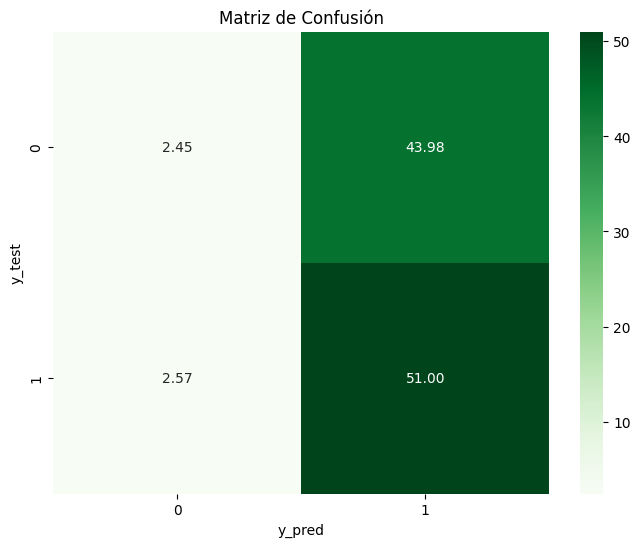

In [53]:
# Matriz de confusión
from sklearn.metrics import confusion_matrix # Import confusion_matrix
import seaborn as sns # Import seaborn

conf_matrix = confusion_matrix(y_test_class, y_pred_class)

# Valores en %
conf_matrix = conf_matrix / np.sum(conf_matrix) * 100

# Plot de la matriz
plt.figure(figsize = (8,6))
sns.heatmap(conf_matrix, annot = True, cmap = 'Greens',
           fmt = '.2f')

plt.title('Matriz de Confusión')
plt.ylabel('Valores Reales')
plt.xlabel('y_pred')
plt.ylabel('y_test')
plt.show()

## Interpretación

Se puede observar que el 94.98 % de las veces, nuestro modelo predice que las acciones de Berkshire Hathaway subirán al día siguiente. El 51,00 % de las veces que nuestro modelo predice una rentabilidad positiva, el mercado efectivamente nos da un día alcista para estas acciones.

En general, el 53,57 % de las veces, nuestro modelo predice correctamente la dirección del día siguiente, ya sea alcista o bajista. Sin embargo, parece que tenemos una mayor ventaja al predecir días alcistas que bajistas.

Desarrollaremos una estrategia en la que solo compraremos acciones cuando nuestro modelo prediga que el día siguiente será alcista, y siempre que prediga una rentabilidad negativa, nos mantendremos fuera del mercado.



In [55]:
X_test['sign'] = y_pred_class #  'signo', indica la dirección del día siguiente
X_test['current_position'] = X_test['sign'].shift(1) # Posición Actual
X_test['model_returns'] = X_test['current_position'] * X_test['returns_in_%'] # Retornos de modelo

In [56]:
X_test

Price,Adj Close,Close,High,Low,Open,Volume,high_low_ratio,open_adjclose_ratio,candle_to_wick_ratio,Close_lag1,...,rsi_overbought,rsi_oversold,cci,obv,obv_divergence_10_days,obv_divergence_20_days,returns_in_%,sign,current_position,model_returns
Date,,,,,,,,,,,,,,,,,,,,,
2018-05-24,194.830002,194.830002,196.259995,193.919998,196.059998,3206200,1.012067,1.006313,-0.525640,195.949997,...,0,0,-63.869518,2988100,-1.445119e+07,-1.118020e+07,-0.57,1,NaN,NaN
2018-05-25,194.149994,194.149994,194.750000,193.210007,193.889999,3031000,1.007971,0.998661,0.168828,194.830002,...,0,0,-89.110808,-42900,-1.356449e+07,-1.677010e+07,-0.35,1,1.0,-0.35
2018-05-29,189.869995,189.869995,193.110001,188.619995,192.899994,8912100,1.023805,1.015958,-0.674832,194.149994,...,0,0,-181.593282,-8955000,-1.921199e+07,-2.143470e+07,-2.20,1,1.0,-2.20
2018-05-30,194.100006,194.100006,194.899994,191.330002,191.899994,4307600,1.018659,0.988666,0.616251,189.869995,...,0,0,-86.427702,-4647400,-1.152440e+07,-2.036210e+07,2.23,1,1.0,2.23
2018-05-31,191.529999,191.529999,194.289993,191.419998,194.289993,5787500,1.014993,1.014410,-0.961672,194.100006,...,0,0,-111.981263,-10434900,-2.023929e+07,-2.226410e+07,-1.32,1,1.0,-1.32
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-05-08,513.250000,513.250000,521.260010,513.039978,520.979980,5018600,1.016022,1.015061,-0.940383,518.219971,...,0,0,-63.164451,283745900,-1.853928e+07,-1.185119e+07,-0.96,1,1.0,-0.96
2025-05-09,513.739990,513.739990,515.909973,510.250000,514.250000,3621400,1.011093,1.000993,-0.090108,513.250000,...,0,0,-85.848069,287367300,-1.217508e+07,-7.538979e+05,0.10,1,1.0,0.10
2025-05-12,514.299988,514.299988,520.299988,510.250000,520.299988,6368000,1.019696,1.011666,-0.597016,513.739990,...,0,0,-67.192337,293735300,-1.568383e+06,-6.168902e+05,0.11,1,1.0,0.11


In [59]:
#!pip install quantstats

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.8/45.8 kB 2.3 MB/s eta 0:00:00


## Finalmente, podemos usar Quantstats para comparar nuestra estrategia con la simple compra y mantenimiento de acciones de Berkshire Hathaway. Quantstats permite obtener no solo la rentabilidad acumulada de ambas estrategias, sino también los riesgos asociados a cada una.

In [61]:
# Valores a decimales
#model_returns = X_test['model_returns'] / 100
#buy_and_hold = X_test['returns_in_%'] / 100


#import quantstats as qs

#qs.reports.full(model_returns, benchmark = buy_and_hold)

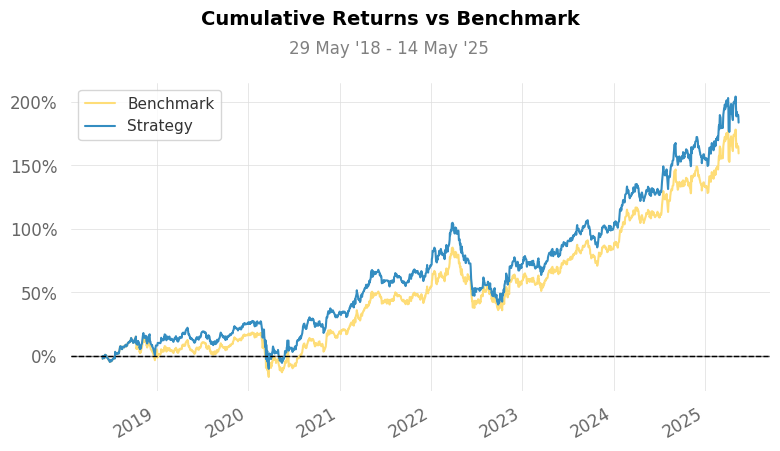

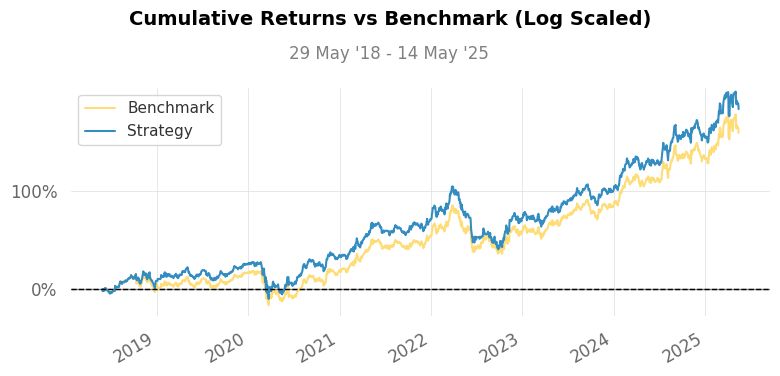

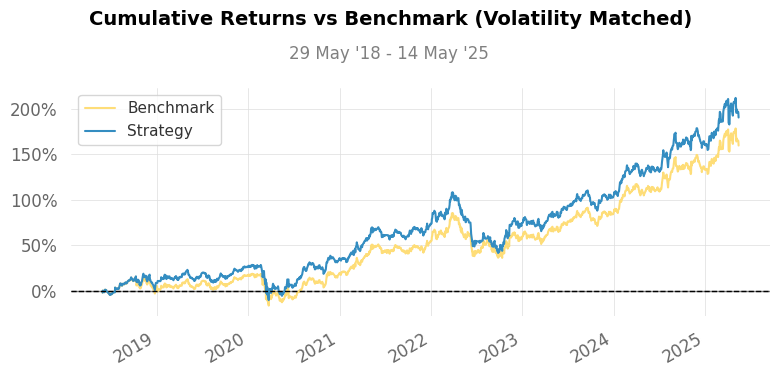

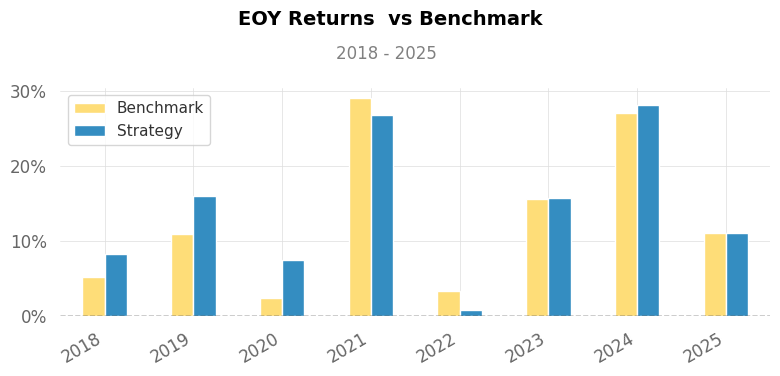

# Comentarios Finales
La estrategia supera consistentemente al benchmark (Buy & Hold) en términos de retornos acumulados.
Esto indica que la estrategia ha generado alfa positivo sostenido en el tiempo.
La escala logarítmica permite ver el crecimiento proporcional, esto sugiere consistencia, no solo “suerte” reciente.

Podemos decir que la estrategia propuesta no solo supera al enfoque tradicional de Buy & Hold en términos absolutos, sino que lo hace con mayor eficiencia en la relación riesgo-retorno. Su comportamiento sostenido en múltiples condiciones de mercado la convierte en una alternativa sólida y potencialmente superior como vehículo de inversión activa.